In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))
import pandas as pd
import matplotlib.pyplot as plt
import logging
import time
from simulation.utils import price_to_sqrtp, liquidity0
from simulation.constants import q96, eth

In [3]:
OHLC_data = pd.read_csv('..\data\eth_all2025.csv')
OHLC_data['timestamp'] = pd.to_datetime(OHLC_data["open_time"]/1000000, unit="s")
price_data_all = OHLC_data.set_index('timestamp')['close']

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cvv\AppData\Local\Temp\ipykernel_8836\2458520560.py:1: SyntaxWarning: invalid escape sequence '\d'
  OHLC_data = pd.read_csv('..\data\eth_all2025.csv')


Analyzing the period from 2025-07-15 23:43:20 to 2025-07-15 23:59:59


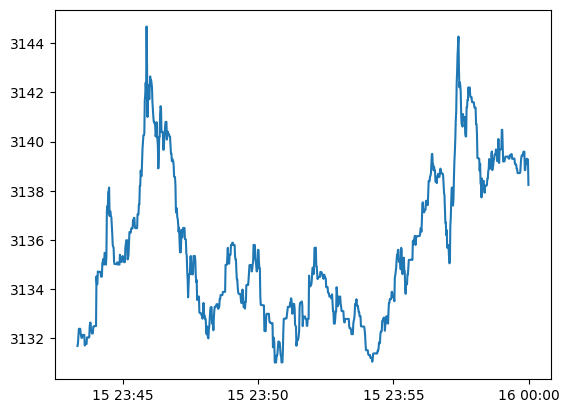

In [4]:
# # Select the time interval for which the simulation will be performed
left = -1000*1 # sec
right = -86400*0 # sec

if right != 0:
  price_data_slice = price_data_all[left: right]
else:
  price_data_slice = price_data_all[left: ]

price_data = price_data_slice.to_numpy()
timestamps_data = price_data_slice.index.to_numpy()

print(f"Analyzing the period from {pd.Timestamp(timestamps_data[0])} to {pd.Timestamp(timestamps_data[-1])}")
plt.plot(timestamps_data, price_data)

In [5]:
# Calculate position parameters for a Uniswap V3-style pool
pa = 2000
pb = 5000
x =  10 * eth
pc = price_data[0]
sqrt_pa = price_to_sqrtp(pa)
sqrt_pb = price_to_sqrtp(pb)
sqrt_pc = price_to_sqrtp(pc)
liq0 = liquidity0(x, sqrt_pc, sqrt_pb)
y = liq0 * (sqrt_pc - sqrt_pa) / q96
print(f'tvl {x/eth * pc + y/eth:.2f}, x {x/eth:.2f}, y {y/eth:.2f}')

tvl 61473.24, x 10.00, y 30156.34


In [18]:
from simulation.logger import logger
from simulation.pool import Pool
from simulation.arbitrage import Arbitrage
from simulation.simulation import Simulation
logger.setLevel(logging.CRITICAL)
sim = Simulation(poolClass=Pool, arbClass=Arbitrage, 
                 blockPerSecondMoreThanOne=False, blockPerSecondOrSecondsPerBlock=4, 
                 filename='result.csv', save_block_info=True)
sim.configure_pool(first_price=price_data[0], fee=0) # 0.003
sim.configure_arb(minGasPrice=0.002, profitToGasRatio=0.1, fee_outside=0, skip=0) # fee_outside=0.00017

sim.poolClass.add_liquidity(id=0, x=x/eth, y=y/eth, pa=pa, pb=pb)

start = time.time()
for i, (timestamp, currentPriceOutside) in enumerate(zip(timestamps_data, price_data)):

  sim.step_second(currentPriceOutside=currentPriceOutside, timestamp=timestamp)

  if i % 100000 == 0:
    logger.critical(f'Сейчас {i} итерация, timestamp: {timestamp}, currentPriceOutside: {currentPriceOutside:.2f}, poolPrice {sim.poolClass.currentPrice:.2f}')

logger.critical(f'симуляция {i} итераций заняла {time.time()-start} секунд')
sim.close_file()

[2025-07-30 14:18:40,324] CRITICAL: Сейчас 0 итерация, timestamp: 2025-07-15T23:43:20.000000000, currentPriceOutside: 3131.69, poolPrice 3131.69
[2025-07-30 14:18:40,361] CRITICAL: симуляция 999 итераций заняла 0.03839588165283203 секунд


In [12]:
res = pd.read_csv('result.csv')

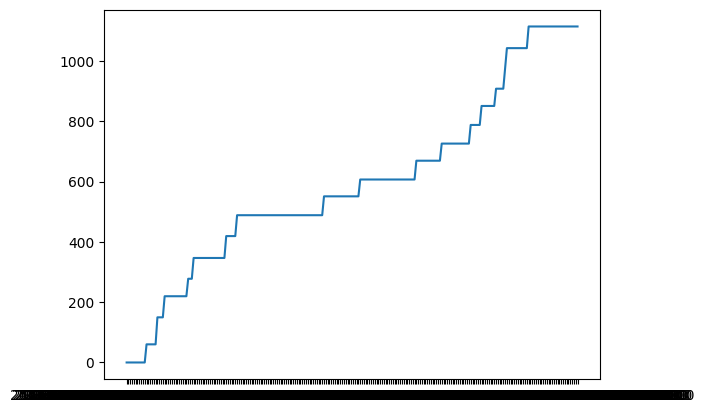

In [13]:
plt.plot(res.timestamp, res.cumulativeVolume)

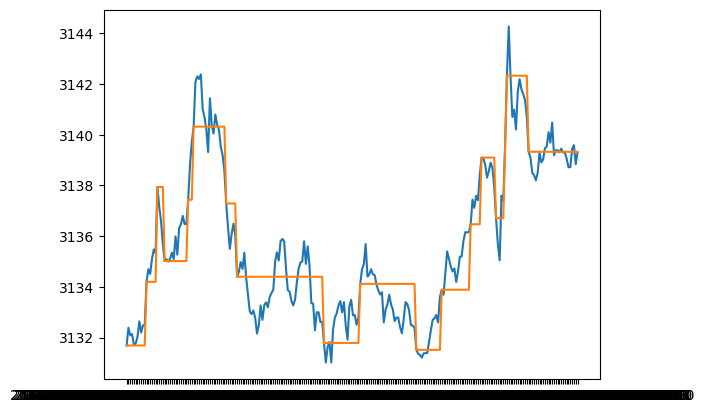

In [15]:
plt.plot(res.timestamp, res.currentPriceOutside)
plt.plot(res.timestamp, res.currentPrice)